# Problem Statement and Analytical Approach

## Problem Statement
The Aadhaar ecosystem supports identity verification for large-scale public
service delivery across India. Due to continuous enrolment and frequent
demographic and biometric updates, operational workload varies significantly
across regions, time periods, and demographic groups. Current planning
mechanisms relying primarily on enrolment volume fail to capture hidden
update-driven workload pressure.

## Analytical Approach
This analysis uses UIDAI-provided aggregated Aadhaar enrolment, demographic
update, and biometric update datasets. The approach examines enrolment and
update activity across temporal, geographic, and age-based dimensions and
introduces normalized indicators to identify disproportionate update pressure
and operational stress.

In [1]:
import pandas as pd


# Merging Datasets

The enrolment, demographic update, and biometric update datasets were
independently loaded and merged after standardization to enable integrated
analysis at the state and monthly level.

In [2]:
DATA_PATH = "Data/"

enrolment_df = pd.concat([
    pd.read_csv(DATA_PATH + "api_data_aadhar_enrolment_0_500000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_enrolment_500000_1000000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_enrolment_1000000_1006029.csv")
], ignore_index=True)

biometric_df = pd.concat([
    pd.read_csv(DATA_PATH + "api_data_aadhar_biometric_0_500000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_biometric_500000_1000000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_biometric_1000000_1500000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_biometric_1500000_1861108.csv")
], ignore_index=True)

demographic_df = pd.concat([
    pd.read_csv(DATA_PATH + "api_data_aadhar_demographic_0_500000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_demographic_500000_1000000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_demographic_1000000_1500000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_demographic_1500000_2000000.csv"),
    pd.read_csv(DATA_PATH + "api_data_aadhar_demographic_2000000_2071700.csv")
], ignore_index=True)


In [3]:
enrolment_df.shape, biometric_df.shape, demographic_df.shape


((1006029, 7), (1861108, 6), (2071700, 6))

In [4]:
enrolment_df.head()


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [5]:
demographic_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [6]:
biometric_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


# Preprocessing

Checking Missing Values

In [7]:
enrolment_df.isna().sum(), biometric_df.isna().sum(), demographic_df.isna().sum()


(date              0
 state             0
 district          0
 pincode           0
 age_0_5           0
 age_5_17          0
 age_18_greater    0
 dtype: int64,
 date            0
 state           0
 district        0
 pincode         0
 bio_age_5_17    0
 bio_age_17_     0
 dtype: int64,
 date             0
 state            0
 district         0
 pincode          0
 demo_age_5_17    0
 demo_age_17_     0
 dtype: int64)

Checking Duplicate Rows

In [8]:

enrolment_df.duplicated().sum(), biometric_df.duplicated().sum(), demographic_df.duplicated().sum()


(np.int64(22957), np.int64(94896), np.int64(473601))

Exact duplicate rows were identified and removed to avoid double-counting
during aggregation and ratio-based indicator computation.

Remove exact duplicate rows

In [9]:

enrolment_df = enrolment_df.drop_duplicates()
biometric_df = biometric_df.drop_duplicates()
demographic_df = demographic_df.drop_duplicates()

enrolment_df.shape, biometric_df.shape, demographic_df.shape


((983072, 7), (1766212, 6), (1598099, 6))

Re-check duplicates after removal

In [10]:
enrolment_df.duplicated().sum(), biometric_df.duplicated().sum(), demographic_df.duplicated().sum()


(np.int64(0), np.int64(0), np.int64(0))

Checking States Formatting

In [11]:
sorted(enrolment_df["state"].unique())


['100000',
 'Andaman & Nicobar Islands',
 'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra & Nagar Haveli',
 'Dadra and Nagar Haveli',
 'Dadra and Nagar Haveli and Daman and Diu',
 'Daman & Diu',
 'Daman and Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu & Kashmir',
 'Jammu And Kashmir',
 'Jammu and Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'ODISHA',
 'Odisha',
 'Orissa',
 'Pondicherry',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'The Dadra And Nagar Haveli And Daman And Diu',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'WEST BENGAL',
 'WESTBENGAL',
 'West  Bengal',
 'West Bangal',
 'West Bengal',
 'West bengal',
 'Westbengal',
 'andhra pradesh']

State names exhibited significant formatting inconsistencies due to variations
in spelling, casing, and administrative restructuring. A normalization
function was applied to standardize state names and merge equivalent
administrative units to ensure accurate aggregation.

In [12]:
def clean_state(series):
    series = (
        series
        .astype(str)
        .str.strip()
        .str.replace("&", "and", regex=False)
        .str.title()
    )

    corrections = {
        # Merged UTs
        "Dadra And Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
        "Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
        "The Dadra And Nagar Haveli And Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",

        # West Bengal variants
        "West  Bengal": "West Bengal",
        "West Bangal": "West Bengal",
        "Westbengal": "West Bengal"
    }

    series = series.replace(corrections)

    # Drop clearly invalid numeric-like states
    series = series.where(~series.str.isnumeric())

    return series


In [13]:
enrolment_df["state"] = clean_state(enrolment_df["state"])
biometric_df["state"] = clean_state(biometric_df["state"])
demographic_df["state"] = clean_state(demographic_df["state"])


In [14]:
enrolment_df = enrolment_df.dropna(subset=["state"])
biometric_df = biometric_df.dropna(subset=["state"])
demographic_df = demographic_df.dropna(subset=["state"])


In [15]:
sorted(enrolment_df["state"].unique())


['Andaman And Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra And Nagar Haveli And Daman And Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu And Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Orissa',
 'Pondicherry',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']

Checking District formatting

In [16]:

for df in [enrolment_df, biometric_df, demographic_df]:
    df["district"] = df["district"].str.strip().str.title()


In [17]:
enrolment_df["district"].unique()[:20]


array(['East Khasi Hills', 'Bengaluru Urban', 'Kanpur Nagar', 'Aligarh',
       'Sitamarhi', 'Bahraich', 'Firozabad', 'Purbi Champaran',
       'Maharajganj', 'Aurangabad', 'Ghaziabad', 'Faridabad', 'Madhubani',
       'Sikar', 'Bhagalpur', 'Amritsar', 'Gurugram',
       'Gautam Buddha Nagar', 'West Delhi', 'Bhind'], dtype=object)

Check invalid PIN codes (not 6 digits)

In [18]:

invalid_pins = enrolment_df[
    ~enrolment_df["pincode"].astype(str).str.match(r"^\d{6}$")
]

invalid_pins.shape


(0, 7)

Check date ranges across all datasets

In [19]:

(
    enrolment_df["date"].min(),
    enrolment_df["date"].max(),
    biometric_df["date"].min(),
    biometric_df["date"].max(),
    demographic_df["date"].min(),
    demographic_df["date"].max()
)


('01-04-2025',
 '31-12-2025',
 '01-03-2025',
 '31-10-2025',
 '01-03-2025',
 '31-10-2025')

Create total enrolment column (age-wise sum)

In [20]:

enrolment_df["total_enrolment"] = (
    enrolment_df["age_0_5"] +
    enrolment_df["age_5_17"] +
    enrolment_df["age_18_greater"]
)

enrolment_df[["age_0_5", "age_5_17", "age_18_greater", "total_enrolment"]].head()


,age_0_5,age_5_17,age_18_greater,total_enrolment
0,11,61,37,109
1,14,33,39,86
2,29,82,12,123
3,62,29,15,106
4,14,16,21,51


Check zero or suspiciously low enrolment rows

In [21]:

(
    (enrolment_df["total_enrolment"] == 0).sum(),
    enrolment_df["total_enrolment"].describe()
)


(np.int64(0),
 count    983051.000000
 mean          5.423468
 std          31.932495
 min           1.000000
 25%           1.000000
 50%           2.000000
 75%           5.000000
 max        3965.000000
 Name: total_enrolment, dtype: float64)

Convert date columns to datetime

In [22]:

enrolment_df["date"] = pd.to_datetime(enrolment_df["date"], errors="coerce")
biometric_df["date"] = pd.to_datetime(biometric_df["date"], errors="coerce")
demographic_df["date"] = pd.to_datetime(demographic_df["date"], errors="coerce")

enrolment_df["date"].dtype, biometric_df["date"].dtype, demographic_df["date"].dtype


(dtype('<M8[ns]'), dtype('<M8[ns]'), dtype('<M8[ns]'))

Common monthly time key

In [23]:

enrolment_df["year_month"] = enrolment_df["date"].dt.to_period("M")
biometric_df["year_month"] = biometric_df["date"].dt.to_period("M")
demographic_df["year_month"] = demographic_df["date"].dt.to_period("M")

enrolment_df[["date", "year_month"]].head()


,date,year_month
0,2025-02-03,2025-02
1,2025-09-03,2025-09
2,2025-09-03,2025-09
3,2025-09-03,2025-09
4,2025-09-03,2025-09


In [24]:

enrolment_df.info()
enrolment_df.head()



<class 'pandas.core.frame.DataFrame'>
Index: 983051 entries, 0 to 1006028
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             319712 non-null  datetime64[ns]
 1   state            983051 non-null  object        
 2   district         983051 non-null  object        
 3   pincode          983051 non-null  int64         
 4   age_0_5          983051 non-null  int64         
 5   age_5_17         983051 non-null  int64         
 6   age_18_greater   983051 non-null  int64         
 7   total_enrolment  983051 non-null  int64         
 8   year_month       319712 non-null  period[M]     
dtypes: datetime64[ns](1), int64(5), object(2), period[M](1)
memory usage: 75.0+ MB


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrolment,year_month
0,2025-02-03,Meghalaya,East Khasi Hills,793121,11,61,37,109,2025-02
1,2025-09-03,Karnataka,Bengaluru Urban,560043,14,33,39,86,2025-09
2,2025-09-03,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123,2025-09
3,2025-09-03,Uttar Pradesh,Aligarh,202133,62,29,15,106,2025-09
4,2025-09-03,Karnataka,Bengaluru Urban,560016,14,16,21,51,2025-09


# ANALYSIS

In [25]:
monthly_enrolment = (
    enrolment_df
    .groupby("year_month", as_index=False)["total_enrolment"]
    .sum()
    .sort_values("year_month")
)

monthly_enrolment.head()


,year_month,total_enrolment
0,2025-01,1366494
1,2025-02,173739
2,2025-03,102911
3,2025-04,66356
4,2025-05,101185


In [26]:
monthly_biometric = (
    biometric_df
    .groupby("year_month", as_index=False)[["bio_age_5_17", "bio_age_17_"]]
    .sum()
    .sort_values("year_month")
)

monthly_biometric.head()


,year_month,bio_age_5_17,bio_age_17_
0,2025-01,20753378,22882990
1,2025-02,638220,568130
2,2025-03,548772,562609
3,2025-04,477663,489116
4,2025-05,367156,398351


In [27]:
monthly_demographic = (
    demographic_df
    .groupby("year_month", as_index=False)[["demo_age_5_17", "demo_age_17_"]]
    .sum()
    .sort_values("year_month")
)

monthly_demographic.head()


,year_month,demo_age_5_17,demo_age_17_
0,2025-01,1372617,12139782
1,2025-02,91104,779590
2,2025-03,101318,879698
3,2025-04,100000,957419
4,2025-05,70069,590329


UNIVARIATE ANALYSIS

In [28]:
monthly_enrolment

,year_month,total_enrolment
0,2025-01,1366494
1,2025-02,173739
2,2025-03,102911
3,2025-04,66356
4,2025-05,101185
5,2025-06,102257
6,2025-07,56194
7,2025-08,133806
8,2025-09,139207
9,2025-10,148246


In [29]:
age_wise_enrolment = enrolment_df[
    ["age_0_5", "age_5_17", "age_18_greater"]
].sum()

age_wise_enrolment


age_0_5           3474389
age_5_17          1690908
age_18_greater     166249
dtype: int64

In [30]:
enrolment_df = enrolment_df.rename(
    columns={'age_18_greater': 'age_18_plus'}
)
age_cols = ['age_0_5', 'age_5_17', 'age_18_plus']

age_summary = enrolment_df[age_cols].sum().reset_index()
age_summary.columns = ['Age Group', 'Total Enrolments']

age_summary['Percentage (%)'] = (
    age_summary['Total Enrolments'] /
    age_summary['Total Enrolments'].sum()
) * 100

age_summary


,Age Group,Total Enrolments,Percentage (%)
0,age_0_5,3474389,65.166633
1,age_5_17,1690908,31.715154
2,age_18_plus,166249,3.118214


In [31]:
monthly_demographic


,year_month,demo_age_5_17,demo_age_17_
0,2025-01,1372617,12139782
1,2025-02,91104,779590
2,2025-03,101318,879698
3,2025-04,100000,957419
4,2025-05,70069,590329
5,2025-06,94191,810067
6,2025-07,64641,551159
7,2025-08,116545,1092242
8,2025-09,79425,671772
9,2025-10,90554,917394


In [32]:
monthly_biometric


,year_month,bio_age_5_17,bio_age_17_
0,2025-01,20753378,22882990
1,2025-02,638220,568130
2,2025-03,548772,562609
3,2025-04,477663,489116
4,2025-05,367156,398351
5,2025-06,493999,461857
6,2025-07,276839,284466
7,2025-08,531137,540756
8,2025-09,532385,517749
9,2025-10,525657,495648


State-wise Total Enrolment

In [33]:
state_enrolment = (
    enrolment_df
    .groupby("state", as_index=False)["total_enrolment"]
    .sum()
    .sort_values("total_enrolment", ascending=False)
)

state_enrolment.head(10)


,state,total_enrolment
35,Uttar Pradesh,1002631
4,Bihar,593753
19,Madhya Pradesh,487892
37,West Bengal,369249
20,Maharashtra,363446
30,Rajasthan,340591
10,Gujarat,275042
3,Assam,225359
15,Karnataka,219618
32,Tamil Nadu,215710


State-wise Demographic

In [34]:
state_demographic = (
    demographic_df
    .groupby("state", as_index=False)[["demo_age_5_17", "demo_age_17_"]]
    .sum()
)

state_demographic.head()


,state,demo_age_5_17,demo_age_17_
0,Andaman And Nicobar Islands,469,4759
1,Andhra Pradesh,227858,1414284
2,Arunachal Pradesh,4558,23833
3,Assam,62971,692126
4,Balanagar,0,1


State-wise Biometric

In [35]:
state_biometric = (
    biometric_df
    .groupby("state", as_index=False)[["bio_age_5_17", "bio_age_17_"]]
    .sum()
)

state_biometric.head()


,state,bio_age_5_17,bio_age_17_
0,Andaman And Nicobar Islands,11354,8640
1,Andhra Pradesh,2181567,1429209
2,Arunachal Pradesh,41143,28916
3,Assam,574106,371044
4,Bihar,2160544,2618424


Share Analysis

In [36]:
state_enrolment["enrolment_share"] = (
    state_enrolment["total_enrolment"] /
    state_enrolment["total_enrolment"].sum()
)

state_enrolment.head(10)


,state,total_enrolment,enrolment_share
35,Uttar Pradesh,1002631,0.188056
4,Bihar,593753,0.111366
19,Madhya Pradesh,487892,0.091510
37,West Bengal,369249,0.069257
20,Maharashtra,363446,0.068169
30,Rajasthan,340591,0.063882
10,Gujarat,275042,0.051588
3,Assam,225359,0.042269
15,Karnataka,219618,0.041192
32,Tamil Nadu,215710,0.040459


Variability Analysis

In [37]:
monthly_enrolment["total_enrolment"].describe()


count    1.200000e+01
mean     2.185179e+05
std      3.630013e+05
min      5.619400e+04
25%      1.019890e+05
50%      1.159100e+05
75%      1.414668e+05
max      1.366494e+06
Name: total_enrolment, dtype: float64

# BIVARIATE ANALYSIS

State-wise enrolment contribution

In [38]:
state_enrolment.head(10)


,state,total_enrolment,enrolment_share
35,Uttar Pradesh,1002631,0.188056
4,Bihar,593753,0.111366
19,Madhya Pradesh,487892,0.091510
37,West Bengal,369249,0.069257
20,Maharashtra,363446,0.068169
30,Rajasthan,340591,0.063882
10,Gujarat,275042,0.051588
3,Assam,225359,0.042269
15,Karnataka,219618,0.041192
32,Tamil Nadu,215710,0.040459


Cumulative contribution

In [39]:
state_enrolment["cumulative_share"] = state_enrolment["enrolment_share"].cumsum()
state_enrolment.head(10)


,state,total_enrolment,enrolment_share,cumulative_share
35,Uttar Pradesh,1002631,0.188056,0.188056
4,Bihar,593753,0.111366,0.299422
19,Madhya Pradesh,487892,0.091510,0.390933
37,West Bengal,369249,0.069257,0.460190
20,Maharashtra,363446,0.068169,0.528359
30,Rajasthan,340591,0.063882,0.592241
10,Gujarat,275042,0.051588,0.643829
3,Assam,225359,0.042269,0.686098
15,Karnataka,219618,0.041192,0.727290
32,Tamil Nadu,215710,0.040459,0.767749


Compare enrolment vs demographic updates

In [40]:
state_enrol_demo = state_enrolment.merge(
    state_demographic,
    on="state",
    how="left"
)

state_enrol_demo.head()


,state,total_enrolment,enrolment_share,cumulative_share,demo_age_5_17,demo_age_17_
0,Uttar Pradesh,1002631,0.188056,0.188056,603453,5857058
1,Bihar,593753,0.111366,0.299422,285883,3352961
2,Madhya Pradesh,487892,0.091510,0.390933,289711,1814924
3,West Bengal,369249,0.069257,0.460190,177260,2667086
4,Maharashtra,363446,0.068169,0.528359,204293,3620598


In [41]:
state_enrol_demo = state_enrolment.merge(
    state_biometric,
    on="state",
    how="left"
)

state_enrol_demo.head()

,state,total_enrolment,enrolment_share,cumulative_share,bio_age_5_17,bio_age_17_
0,Uttar Pradesh,1002631,0.188056,0.188056,6076420,3290663
1,Bihar,593753,0.111366,0.299422,2160544,2618424
2,Madhya Pradesh,487892,0.091510,0.390933,3148670,2671066
3,West Bengal,369249,0.069257,0.460190,1023454,1458738
4,Maharashtra,363446,0.068169,0.528359,3437083,5583627


Merge biometric data

In [42]:
state_enrol_demo_bio = state_enrol_demo.merge(
    state_biometric,
    on="state",
    how="left"
)

state_enrol_demo_bio.head()


,state,total_enrolment,enrolment_share,cumulative_share,bio_age_5_17_x,bio_age_17__x,bio_age_5_17_y,bio_age_17__y
0,Uttar Pradesh,1002631,0.188056,0.188056,6076420,3290663,6076420,3290663
1,Bihar,593753,0.111366,0.299422,2160544,2618424,2160544,2618424
2,Madhya Pradesh,487892,0.091510,0.390933,3148670,2671066,3148670,2671066
3,West Bengal,369249,0.069257,0.460190,1023454,1458738,1023454,1458738
4,Maharashtra,363446,0.068169,0.528359,3437083,5583627,3437083,5583627


update-to-enrolment ratios

In [43]:
state_enrol_demo_bio["demo_update_ratio"] = (
    (state_enrol_demo_bio["demo_age_5_17"] +
     state_enrol_demo_bio["demo_age_17_"]) /
    state_enrol_demo_bio["total_enrolment"]
)

state_enrol_demo_bio["bio_update_ratio"] = (
    (state_enrol_demo_bio["bio_age_5_17"] +
     state_enrol_demo_bio["bio_age_17_"]) /
    state_enrol_demo_bio["total_enrolment"]
)

state_enrol_demo_bio.head()


KeyError: 'demo_age_5_17'

Sort by biometric pressure

In [ ]:
state_enrol_demo_bio.sort_values(
    "bio_update_ratio", ascending=False
).head(10)


,state,total_enrolment,enrolment_share,cumulative_share,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,demo_update_ratio,bio_update_ratio
36,Andaman And Nicobar Islands,501,0.000094,0.999963,469,4759,11354,8640,10.435130,39.908184
30,Goa,2280,0.000428,0.998451,2613,25078,33143,33411,12.145175,29.190351
12,Andhra Pradesh,124273,0.023309,0.844056,227858,1414284,2181567,1429209,13.213989,29.055193
29,Chandigarh,2620,0.000491,0.998024,8865,48530,48687,24865,21.906489,28.073282
25,Tripura,11008,0.002065,0.994894,9079,95504,144132,141192,9.500636,25.919695
15,Chhattisgarh,99773,0.018714,0.905091,117797,1303570,839392,1719714,14.246008,25.649284
4,Maharashtra,363446,0.068169,0.528359,204293,3620598,3437083,5583627,10.523960,24.819946
33,Puducherry,1723,0.000323,0.999517,3102,15794,21389,20195,10.966918,24.134649
37,Lakshadweep,199,0.000037,1.000000,131,782,2195,2550,4.587940,23.844221
22,Himachal Pradesh,16909,0.003172,0.987459,15087,100726,184098,201166,6.849193,22.784553


Sort by demographic churn

In [ ]:
state_enrol_demo_bio.sort_values(
    "demo_update_ratio", ascending=False
).head(10)


,state,total_enrolment,enrolment_share,cumulative_share,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,demo_update_ratio,bio_update_ratio
29,Chandigarh,2620,0.000491,0.998024,8865,48530,48687,24865,21.906489,28.073282
24,Manipur,13199,0.002476,0.992829,31966,201416,162366,113534,17.681794,20.903099
15,Chhattisgarh,99773,0.018714,0.905091,117797,1303570,839392,1719714,14.246008,25.649284
12,Andhra Pradesh,124273,0.023309,0.844056,227858,1414284,2181567,1429209,13.213989,29.055193
30,Goa,2280,0.000428,0.998451,2613,25078,33143,33411,12.145175,29.190351
33,Puducherry,1723,0.000323,0.999517,3102,15794,21389,20195,10.966918,24.134649
4,Maharashtra,363446,0.068169,0.528359,204293,3620598,3437083,5583627,10.523960,24.819946
17,Delhi,92838,0.017413,0.940339,118037,851629,545395,736549,10.444710,13.808397
36,Andaman And Nicobar Islands,501,0.000094,0.999963,469,4759,11354,8640,10.435130,39.908184
11,Telangana,128948,0.024186,0.820747,181851,1053742,909878,768399,9.582103,13.015146


# TRIVARIATE ANALYSIS

Monthly age-wise enrolment

In [ ]:
monthly_age_enrolment = (
    enrolment_df
    .groupby("year_month", as_index=False)[
        ["age_0_5", "age_5_17", "age_18_greater"]
    ]
    .sum()
    .sort_values("year_month")
)

monthly_age_enrolment.head(10)


KeyError: "Columns not found: 'age_18_greater'"

Monthly age-wise biometric updates

In [ ]:
monthly_bio_age = (
    biometric_df
    .groupby("year_month", as_index=False)[
        ["bio_age_5_17", "bio_age_17_"]
    ]
    .sum()
    .sort_values("year_month")
)

monthly_bio_age.head()


,year_month,bio_age_5_17,bio_age_17_
0,2025-01,20753378,22882990
1,2025-02,638220,568130
2,2025-03,548772,562609
3,2025-04,477663,489116
4,2025-05,367156,398351


Time × Enrolment × Update Intensity

In [ ]:
monthly_combined = (
    monthly_enrolment
    .merge(monthly_biometric, on="year_month", how="left")
    .merge(monthly_demographic, on="year_month", how="left")
)

monthly_combined.head()


,year_month,total_enrolment,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_
0,2025-01,1366494,20753378,22882990,1372617,12139782
1,2025-02,173739,638220,568130,91104,779590
2,2025-03,102911,548772,562609,101318,879698
3,2025-04,66356,477663,489116,100000,957419
4,2025-05,101185,367156,398351,70069,590329


monthly update intensity ratios

In [ ]:
monthly_combined["bio_update_intensity"] = (
    (monthly_combined["bio_age_5_17"] +
     monthly_combined["bio_age_17_"]) /
    monthly_combined["total_enrolment"]
)

monthly_combined["demo_update_intensity"] = (
    (monthly_combined["demo_age_5_17"] +
     monthly_combined["demo_age_17_"]) /
    monthly_combined["total_enrolment"]
)

monthly_combined.head()


NameError: name 'monthly_combined' is not defined

Monthly state-level aggregation

In [ ]:
state_monthly = (
    enrolment_df
    .groupby(["state", "year_month"], as_index=False)["total_enrolment"]
    .sum()
)

state_monthly_updates = (
    biometric_df
    .groupby(["state", "year_month"], as_index=False)[
        ["bio_age_5_17", "bio_age_17_"]
    ]
    .sum()
)

state_monthly_combined = state_monthly.merge(
    state_monthly_updates,
    on=["state", "year_month"],
    how="left"
)

state_monthly_combined.head()


,state,year_month,total_enrolment,bio_age_5_17,bio_age_17_
0,Andaman And Nicobar Islands,2025-01,30,6467,6083
1,Andaman And Nicobar Islands,2025-02,12,332,148
2,Andaman And Nicobar Islands,2025-03,15,229,122
3,Andaman And Nicobar Islands,2025-04,17,207,94
4,Andaman And Nicobar Islands,2025-05,9,240,100


State–month biometric pressure ratio

In [ ]:
state_monthly_combined["bio_pressure_ratio"] = (
    (state_monthly_combined["bio_age_5_17"] +
     state_monthly_combined["bio_age_17_"]) /
    state_monthly_combined["total_enrolment"]
)

state_monthly_combined.head()


,state,year_month,total_enrolment,bio_age_5_17,bio_age_17_,bio_pressure_ratio
0,Andaman And Nicobar Islands,2025-01,30,6467,6083,418.333333
1,Andaman And Nicobar Islands,2025-02,12,332,148,40.000000
2,Andaman And Nicobar Islands,2025-03,15,229,122,23.400000
3,Andaman And Nicobar Islands,2025-04,17,207,94,17.705882
4,Andaman And Nicobar Islands,2025-05,9,240,100,37.777778


# VISUALISATION


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


# UNIVARIATE VISUALISATIONS

Monthly Aadhaar Enrolment Trend

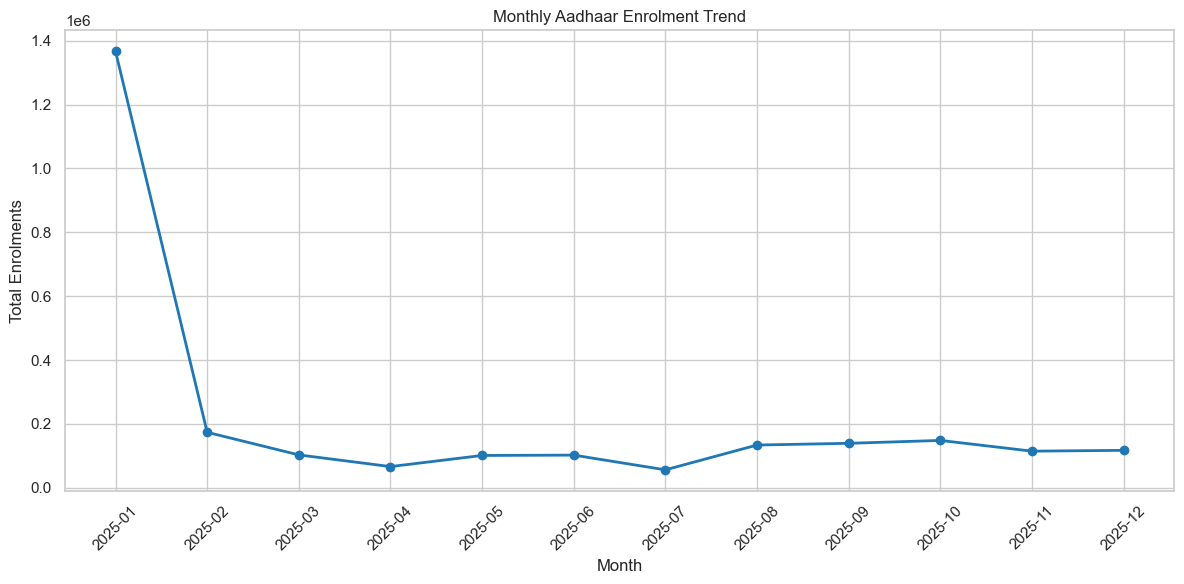

In [ ]:
plt.plot(
    monthly_enrolment["year_month"].astype(str),
    monthly_enrolment["total_enrolment"],
    color="#1f77b4",
    marker="o",
    linewidth=2
)
plt.xticks(rotation=45)
plt.title("Monthly Aadhaar Enrolment Trend")
plt.xlabel("Month")
plt.ylabel("Total Enrolments")
plt.tight_layout()
plt.show()


Age-wise Enrolment Distribution

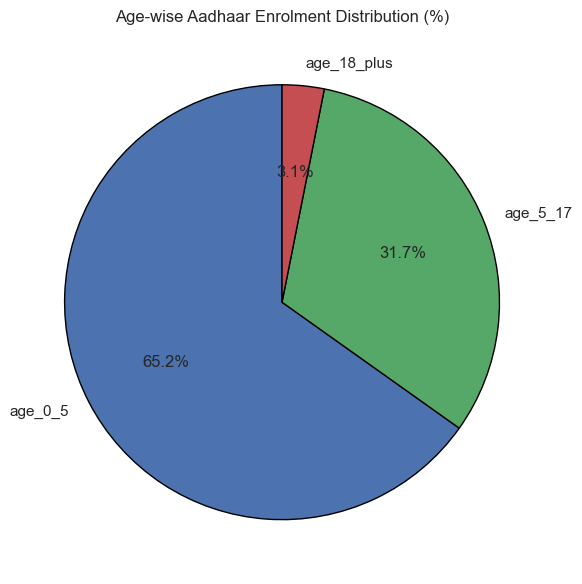

In [ ]:
plt.pie(
    age_summary['Percentage (%)'],
    labels=age_summary['Age Group'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4C72B0', '#55A868', '#C44E52'],  # professional color palette
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Age-wise Aadhaar Enrolment Distribution (%)')

plt.tight_layout()
plt.show()


Monthly Biometric Updates by Age

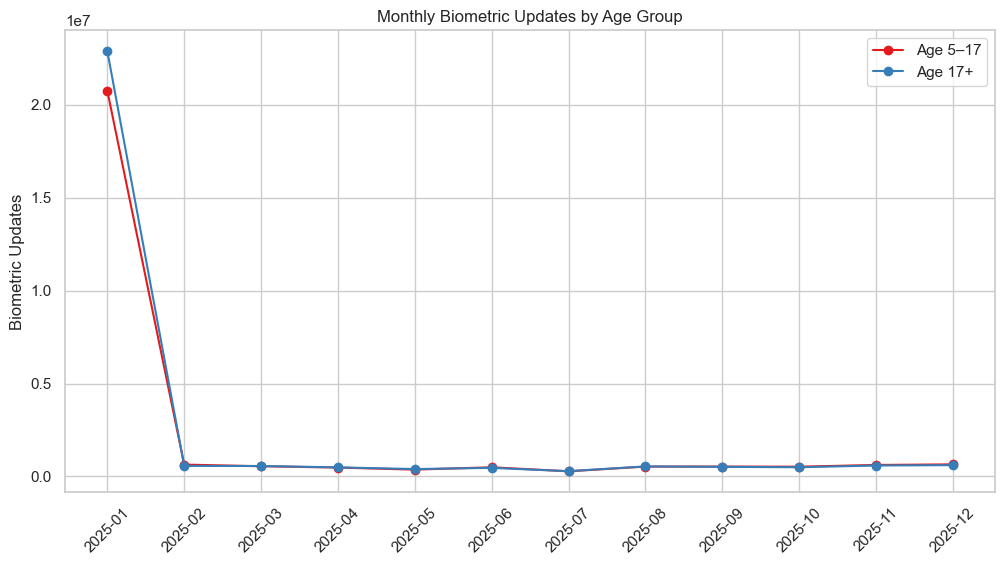

In [ ]:
plt.plot(
    monthly_biometric["year_month"].astype(str),
    monthly_biometric["bio_age_5_17"],
    label="Age 5–17",
    color="#e41a1c",
    marker="o"
)

plt.plot(
    monthly_biometric["year_month"].astype(str),
    monthly_biometric["bio_age_17_"],
    label="Age 17+",
    color="#377eb8",
    marker="o"
)

plt.legend()
plt.xticks(rotation=45)
plt.title("Monthly Biometric Updates by Age Group")
plt.ylabel("Biometric Updates")
plt.show()


Monthly Demographic Updates

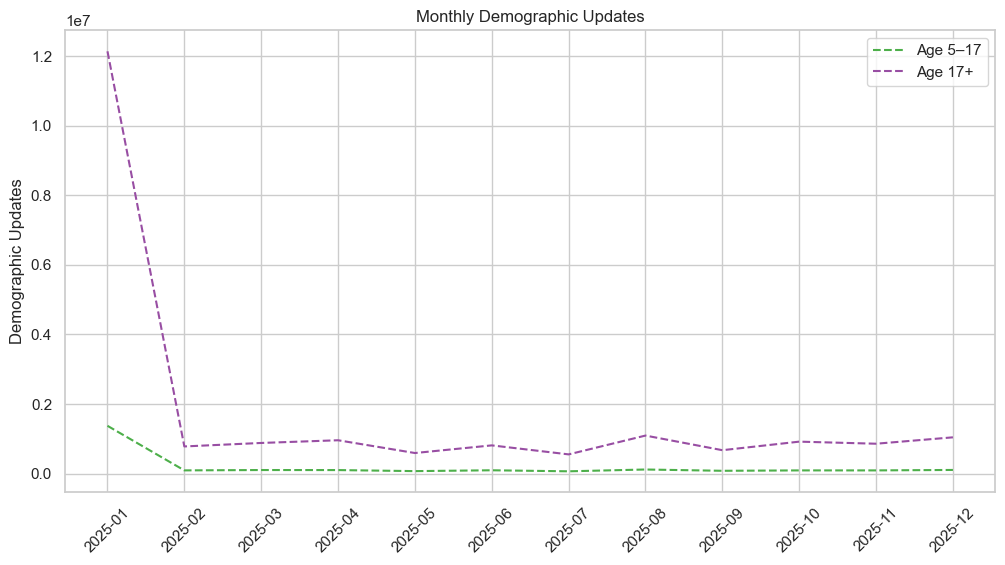

In [ ]:
plt.plot(
    monthly_demographic["year_month"].astype(str),
    monthly_demographic["demo_age_5_17"],
    linestyle="--",
    color="#4daf4a",
    label="Age 5–17"
)

plt.plot(
    monthly_demographic["year_month"].astype(str),
    monthly_demographic["demo_age_17_"],
    linestyle="--",
    color="#984ea3",
    label="Age 17+"
)

plt.legend()
plt.xticks(rotation=45)
plt.title("Monthly Demographic Updates")
plt.ylabel("Demographic Updates")
plt.show()


Top 10 States by Enrolment

C:\Users\Priyanshu Singh\AppData\Local\Temp\ipykernel_4964\1104571096.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


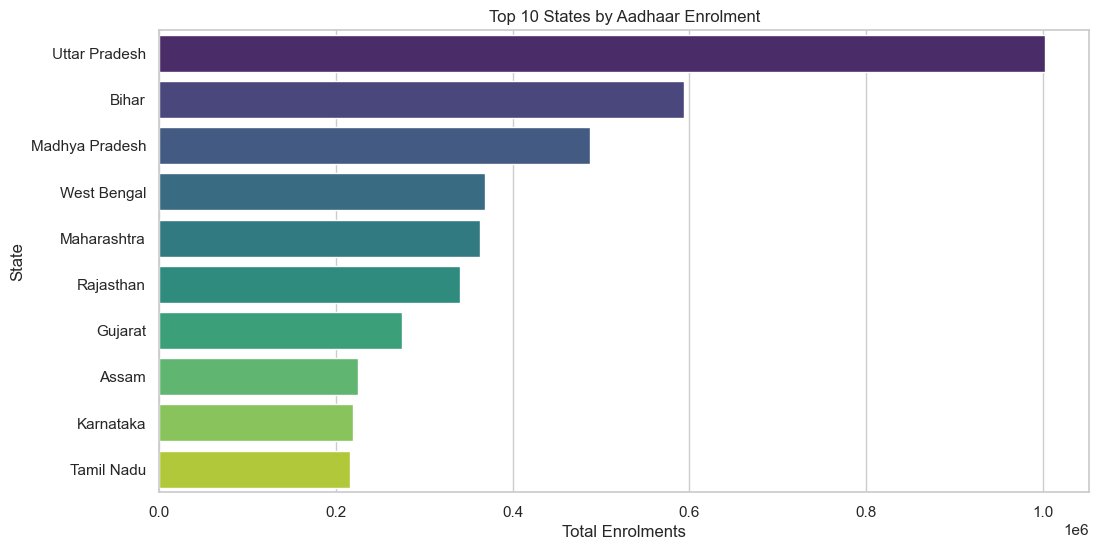

In [ ]:
top_states = state_enrolment.head(10)

sns.barplot(
    x="total_enrolment",
    y="state",
    data=top_states,
    palette="viridis"
)

plt.title("Top 10 States by Aadhaar Enrolment")
plt.xlabel("Total Enrolments")
plt.ylabel("State")
plt.show()


State-wise Biometric Pressure Spread

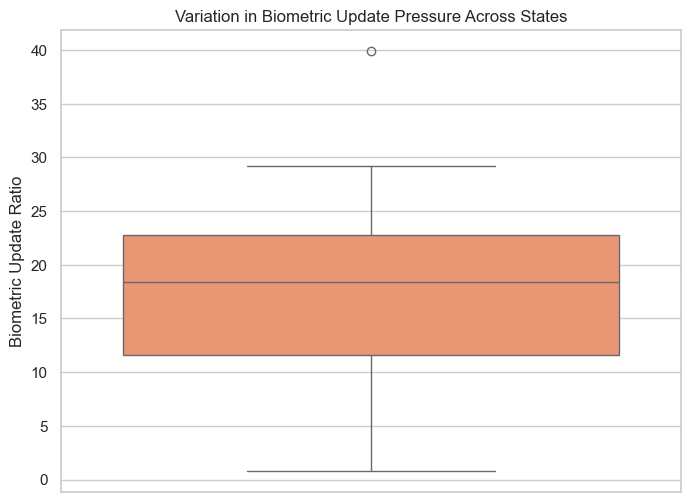

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    y=state_enrol_demo_bio["bio_update_ratio"],
    color="#fc8d62"
)

plt.title("Variation in Biometric Update Pressure Across States")
plt.ylabel("Biometric Update Ratio")
plt.show()


Enrolment Concentration Curve

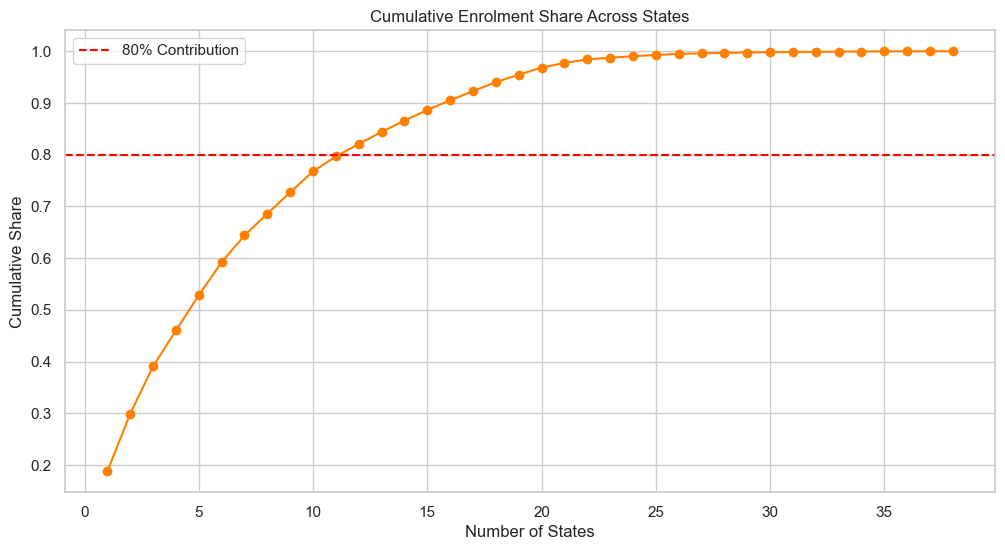

In [ ]:
plt.plot(
    range(1, len(state_enrolment)+1),
    state_enrolment["cumulative_share"],
    color="#ff7f00",
    marker="o"
)

plt.axhline(0.8, linestyle="--", color="red", label="80% Contribution")
plt.legend()
plt.title("Cumulative Enrolment Share Across States")
plt.xlabel("Number of States")
plt.ylabel("Cumulative Share")
plt.show()


# BIVARIATE VISUALISATIONS

In [ ]:
enrol_state = (
    enrolment_df
    .groupby('state', as_index=False)['total_enrolment']
    .sum()
)


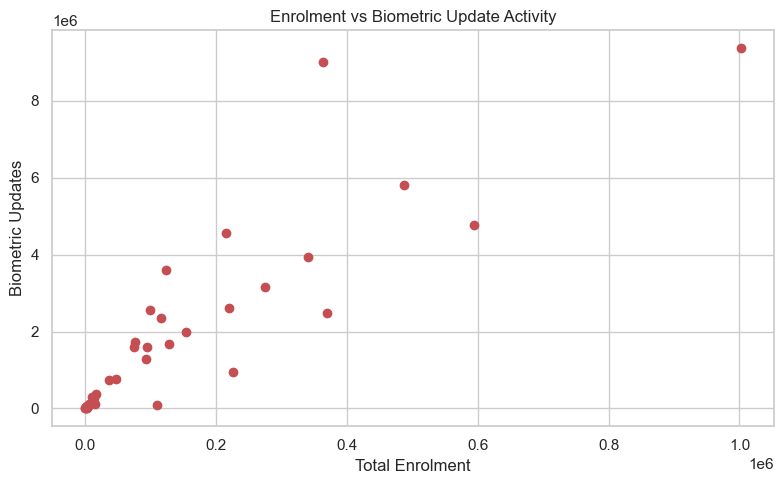

In [ ]:
bio_state = (
    biometric_df
    .groupby('state', as_index=False)[
        ['bio_age_5_17', 'bio_age_17_']
    ]
    .sum()
)

bio_state['total_bio_updates'] = (
    bio_state['bio_age_5_17'] +
    bio_state['bio_age_17_']
)

bio_compare = enrol_state.merge(bio_state, on='state')

plt.figure(figsize=(8, 5))
plt.scatter(
    bio_compare['total_enrolment'],
    bio_compare['total_bio_updates'],
    color='#C44E52'
)

plt.xlabel('Total Enrolment')
plt.ylabel('Biometric Updates')
plt.title('Enrolment vs Biometric Update Activity')
plt.grid(True)

plt.tight_layout()
plt.show()


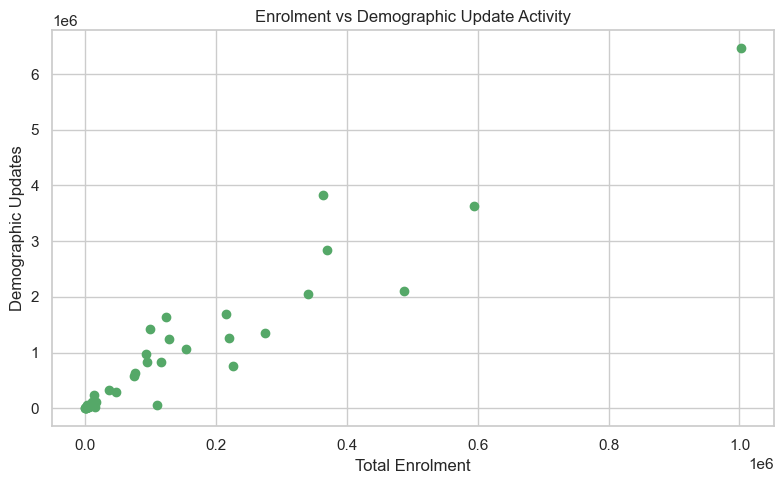

In [ ]:
demo_state = (
    demographic_df
    .groupby('state', as_index=False)[
        ['demo_age_5_17', 'demo_age_17_']
    ]
    .sum()
)

demo_state['total_demo_updates'] = (
    demo_state['demo_age_5_17'] +
    demo_state['demo_age_17_']
)

enrol_state = (
    enrolment_df
    .groupby('state', as_index=False)['total_enrolment']
    .sum()
)

demo_compare = enrol_state.merge(demo_state, on='state')

plt.figure(figsize=(8, 5))
plt.scatter(
    demo_compare['total_enrolment'],
    demo_compare['total_demo_updates'],
    color='#55A868'
)

plt.xlabel('Total Enrolment')
plt.ylabel('Demographic Updates')
plt.title('Enrolment vs Demographic Update Activity')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
update_compare = demo_state[['state', 'total_demo_updates']] \
    .merge(
        bio_state[['state', 'total_bio_updates']],
        on='state'
    )


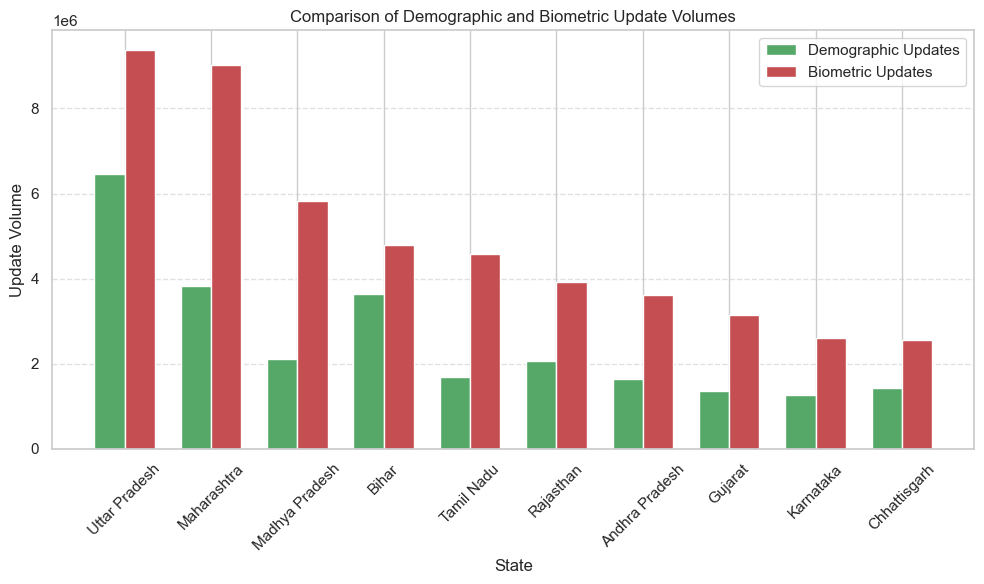

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select top states to avoid clutter
update_compare_top = update_compare.sort_values(
    by='total_bio_updates',
    ascending=False
).head(10)

x = np.arange(len(update_compare_top['state']))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(
    x - width/2,
    update_compare_top['total_demo_updates'],
    width,
    label='Demographic Updates',
    color='#55A868'
)

plt.bar(
    x + width/2,
    update_compare_top['total_bio_updates'],
    width,
    label='Biometric Updates',
    color='#C44E52'
)

plt.xlabel('State')
plt.ylabel('Update Volume')
plt.title('Comparison of Demographic and Biometric Update Volumes')
plt.xticks(x, update_compare_top['state'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Top 10 States by Biometric Pressure

C:\Users\Priyanshu Singh\AppData\Local\Temp\ipykernel_11560\1964148530.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


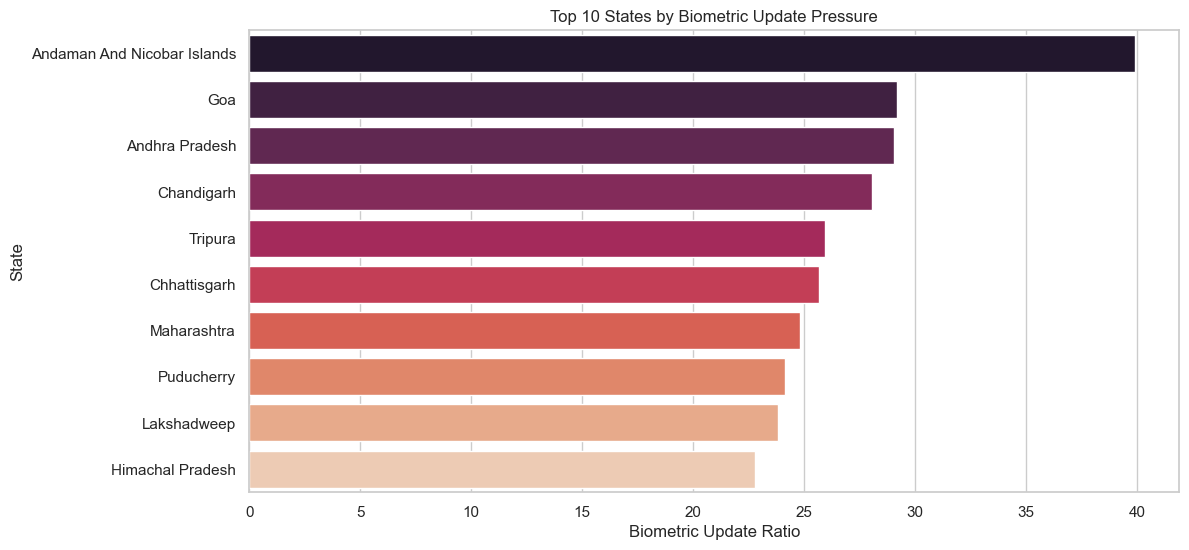

In [ ]:
top_pressure = state_enrol_demo_bio.sort_values(
    "bio_update_ratio", ascending=False
).head(10)

sns.barplot(
    x="bio_update_ratio",
    y="state",
    data=top_pressure,
    palette="rocket"
)

plt.title("Top 10 States by Biometric Update Pressure")
plt.xlabel("Biometric Update Ratio")
plt.ylabel("State")
plt.show()


Relationship Between Demographic Churn and Biometric Pressure

In [ ]:
if "pressure_category" not in state_enrol_demo_bio.columns:
    state_enrol_demo_bio["pressure_category"] = pd.qcut(
        state_enrol_demo_bio["bio_update_ratio"],
        q=3,
        labels=["Low Pressure", "Medium Pressure", "High Pressure"]
    )

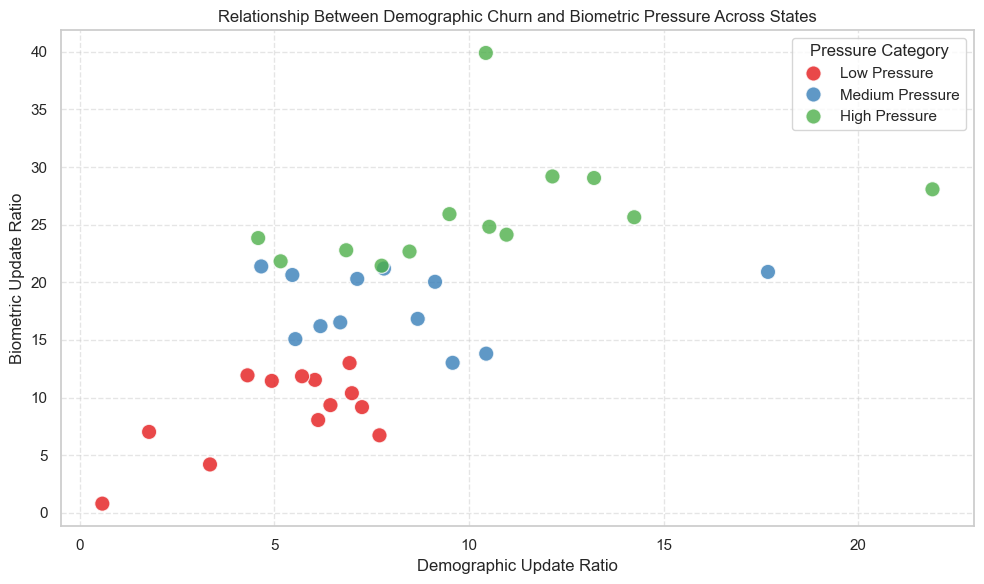

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=state_enrol_demo_bio,
    x="demo_update_ratio",
    y="bio_update_ratio",
    hue="pressure_category",
    palette="Set1",
    s=120,
    alpha=0.8
)

plt.title("Relationship Between Demographic Churn and Biometric Pressure Across States")
plt.xlabel("Demographic Update Ratio")
plt.ylabel("Biometric Update Ratio")
plt.legend(title="Pressure Category")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# TRIVARIATE / STRESS VISUALISATIONS

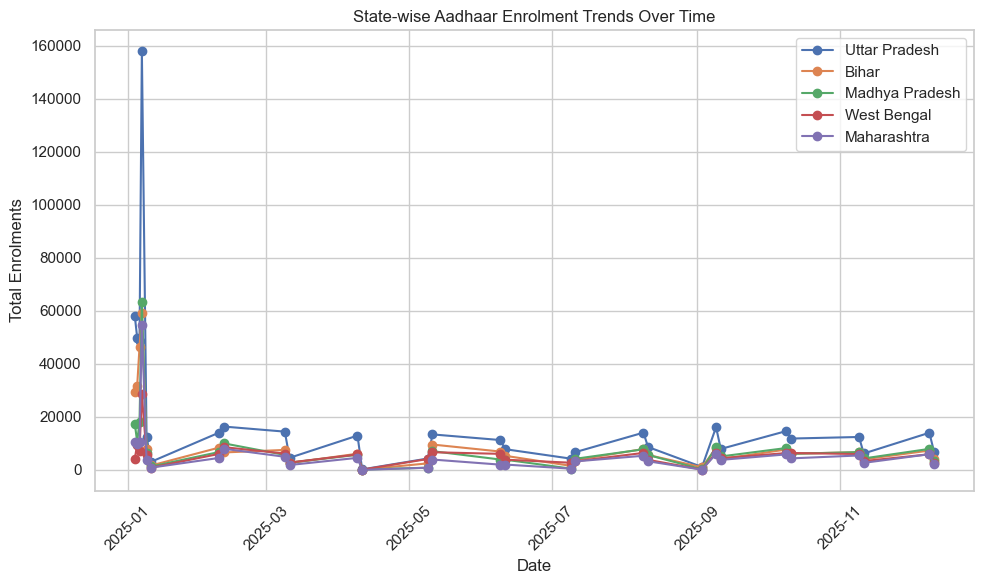

In [ ]:
import matplotlib.pyplot as plt

# Select top states by total enrolment
top_states = (
    enrolment_df
    .groupby('state')['total_enrolment']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filter data for top states
enrol_time_state = enrolment_df[
    enrolment_df['state'].isin(top_states)
]

# Aggregate by date and state
enrol_time_state = (
    enrol_time_state
    .groupby(['date', 'state'], as_index=False)['total_enrolment']
    .sum()
)

# Plot
plt.figure(figsize=(10, 6))

for state in top_states:
    state_data = enrol_time_state[enrol_time_state['state'] == state]
    plt.plot(
        state_data['date'],
        state_data['total_enrolment'],
        marker='o',
        label=state
    )

plt.xlabel('Date')
plt.ylabel('Total Enrolments')
plt.title('State-wise Aadhaar Enrolment Trends Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Age-wise Enrolment Over Time

In [ ]:
# Fix column names (if not already fixed)
enrolment_df = enrolment_df.rename(
    columns={'age_18_greater': 'age_18_plus'}
)

demographic_df = demographic_df.rename(
    columns={'demo_age_17_': 'demo_age_18_plus'}
)

biometric_df = biometric_df.rename(
    columns={'bio_age_17_': 'bio_age_18_plus'}
)


In [ ]:
# Aggregate age-wise demographic updates
demo_age_summary = demographic_df[
    ['demo_age_5_17', 'demo_age_18_plus']
].sum()

# Aggregate age-wise biometric updates
bio_age_summary = biometric_df[
    ['bio_age_5_17', 'bio_age_18_plus']
].sum()

# Create summary table
age_update_table = {
    'Age Group': ['5–17 years', '18+ years'],
    'Demographic Updates': [
        demo_age_summary['demo_age_5_17'],
        demo_age_summary['demo_age_18_plus']
    ],
    'Biometric Updates': [
        bio_age_summary['bio_age_5_17'],
        bio_age_summary['bio_age_18_plus']
    ]
}

age_update_df = pd.DataFrame(age_update_table)
age_update_df



,Age Group,Demographic Updates,Biometric Updates
0,5–17 years,3597737,33456647
1,18+ years,32999820,34804412


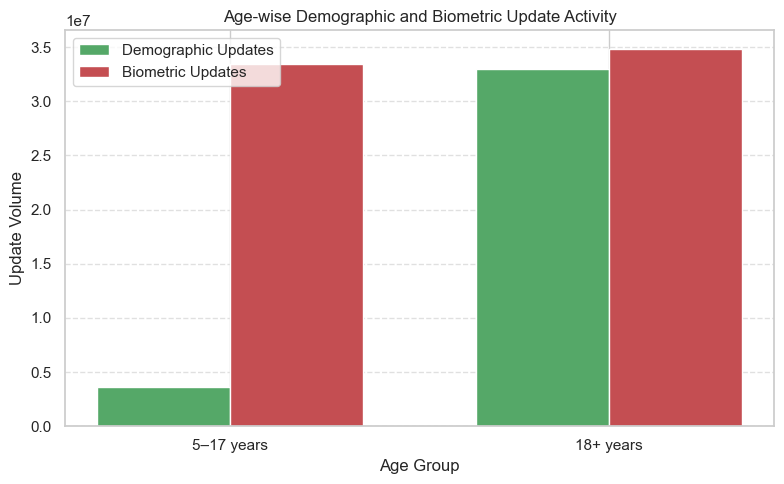

In [ ]:
import numpy as np

x = np.arange(len(age_update_df['Age Group']))
width = 0.35

plt.figure(figsize=(8, 5))

plt.bar(
    x - width/2,
    age_update_df['Demographic Updates'],
    width,
    label='Demographic Updates',
    color='#55A868'
)

plt.bar(
    x + width/2,
    age_update_df['Biometric Updates'],
    width,
    label='Biometric Updates',
    color='#C44E52'
)

plt.xlabel('Age Group')
plt.ylabel('Update Volume')
plt.title('Age-wise Demographic and Biometric Update Activity')
plt.xticks(x, age_update_df['Age Group'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


State-wise Enrolment Volume, Biometric Pressure, and Demographic Churn

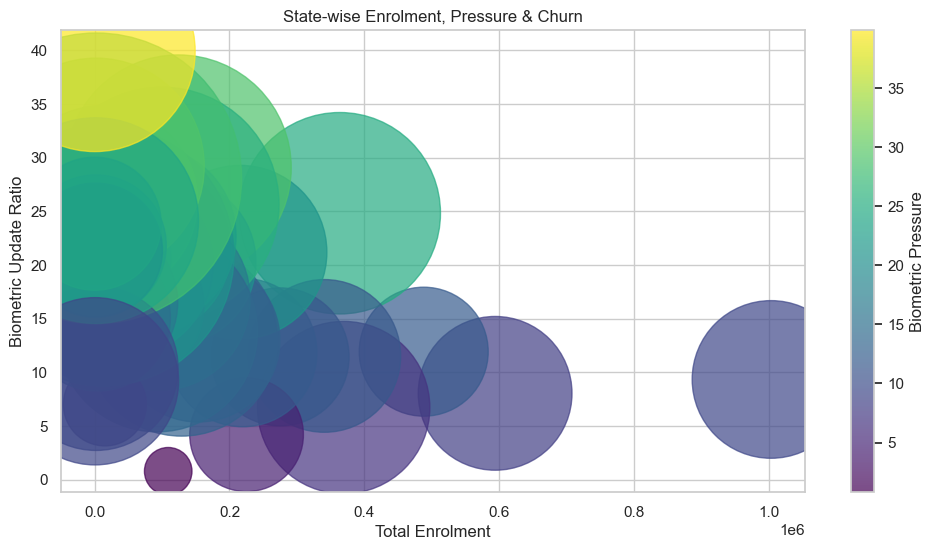

In [ ]:
plt.scatter(
    state_enrol_demo_bio["total_enrolment"],
    state_enrol_demo_bio["bio_update_ratio"],
    s=state_enrol_demo_bio["demo_update_ratio"] * 2000,
    c=state_enrol_demo_bio["bio_update_ratio"],
    cmap="viridis",
    alpha=0.7
)

plt.colorbar(label="Biometric Pressure")
plt.title("State-wise Enrolment, Pressure & Churn")
plt.xlabel("Total Enrolment")
plt.ylabel("Biometric Update Ratio")
plt.show()


C:\Users\Priyanshu Singh\AppData\Local\Temp\ipykernel_4964\4198477343.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_time_state['total_bio_updates'] = (


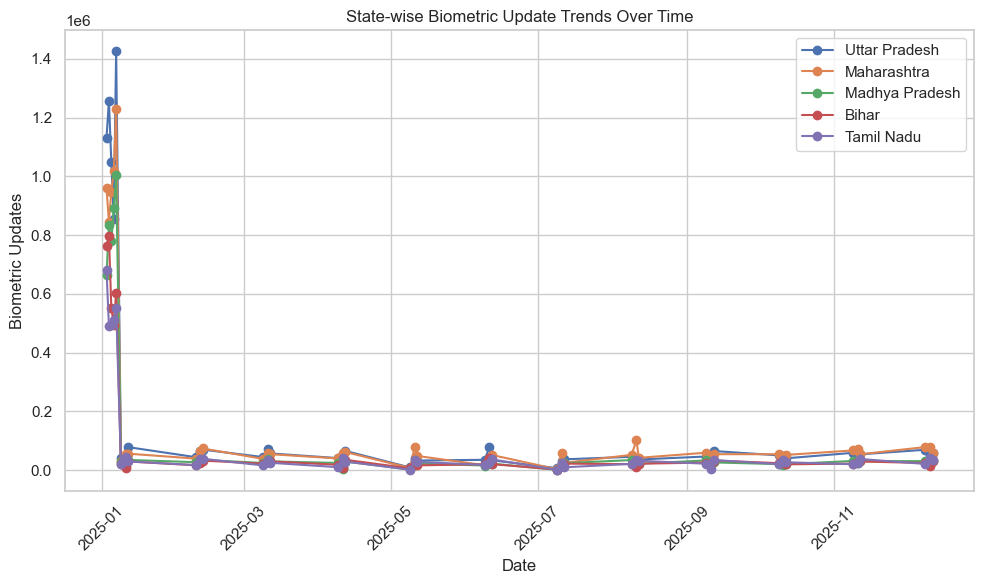

In [ ]:
# Select top states by biometric updates
top_update_states = (
    biometric_df
    .groupby('state')[['bio_age_5_17', 'bio_age_18_plus']]
    .sum()
    .sum(axis=1)
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Prepare time-series update data
bio_time_state = biometric_df[
    biometric_df['state'].isin(top_update_states)
]

bio_time_state['total_bio_updates'] = (
    bio_time_state['bio_age_5_17'] +
    bio_time_state['bio_age_18_plus']
)

bio_time_state = (
    bio_time_state
    .groupby(['date', 'state'], as_index=False)['total_bio_updates']
    .sum()
)

# Plot
plt.figure(figsize=(10, 6))

for state in top_update_states:
    state_data = bio_time_state[bio_time_state['state'] == state]
    plt.plot(
        state_data['date'],
        state_data['total_bio_updates'],
        marker='o',
        label=state
    )

plt.xlabel('Date')
plt.ylabel('Biometric Updates')
plt.title('State-wise Biometric Update Trends Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Update Intensity Distribution

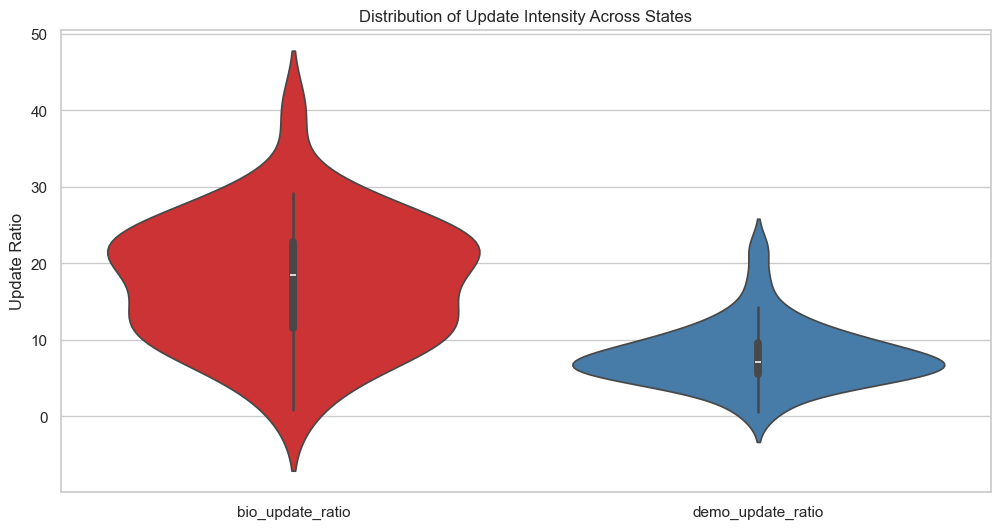

In [ ]:
sns.violinplot(
    data=state_enrol_demo_bio[["bio_update_ratio", "demo_update_ratio"]],
    palette=["#e41a1c", "#377eb8"]
)

plt.title("Distribution of Update Intensity Across States")
plt.ylabel("Update Ratio")
plt.show()


State × Month Biometric Pressure

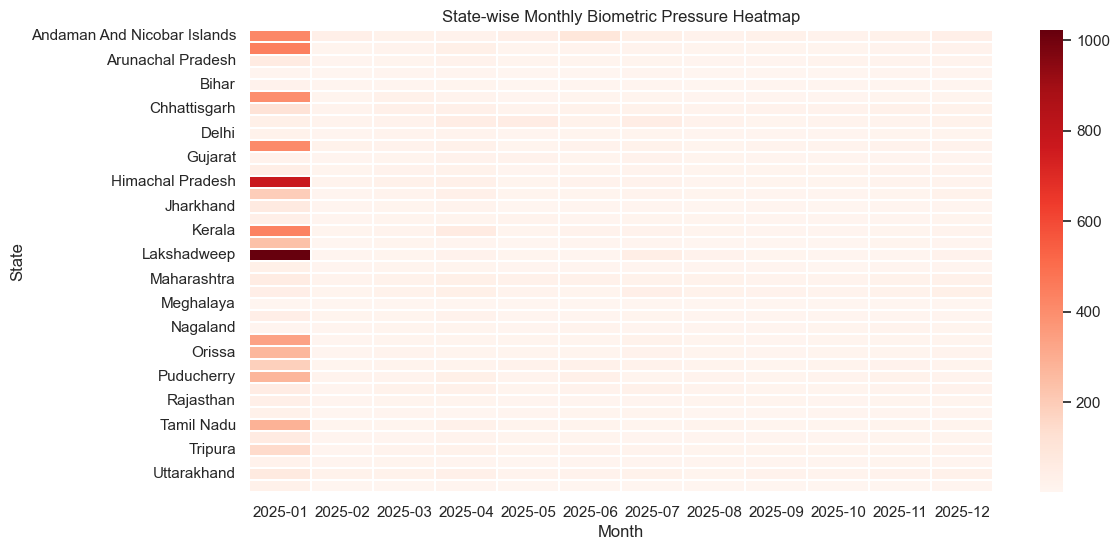

In [ ]:
pivot_pressure = state_monthly_combined.pivot(
    index="state",
    columns="year_month",
    values="bio_pressure_ratio"
)

sns.heatmap(
    pivot_pressure,
    cmap="Reds",
    linewidths=0.3
)

plt.title("State-wise Monthly Biometric Pressure Heatmap")
plt.xlabel("Month")
plt.ylabel("State")
plt.show()


Interrelationships Between Enrolment Volume and Update Intensities Across States

In [ ]:
# Create pressure category for coloring
state_enrol_demo_bio["pressure_category"] = pd.qcut(
    state_enrol_demo_bio["bio_update_ratio"],
    q=3,
    labels=["Low Pressure", "Medium Pressure", "High Pressure"]
)


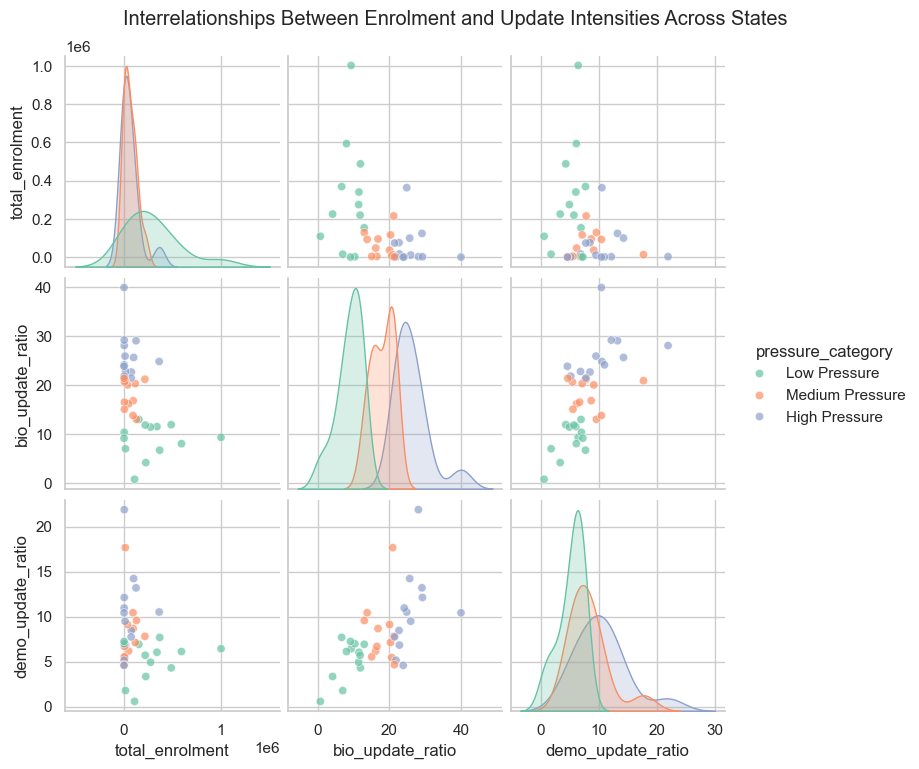

In [ ]:
sns.pairplot(
    state_enrol_demo_bio,
    vars=["total_enrolment", "bio_update_ratio", "demo_update_ratio"],
    hue="pressure_category",
    palette="Set2",
    diag_kind="kde",
    plot_kws={"alpha": 0.7}
)

plt.suptitle(
    "Interrelationships Between Enrolment and Update Intensities Across States",
    y=1.02
)
plt.show()
